In [5]:
# %% [markdown]
# # Notebook 03 — Evaluation

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score, confusion_matrix, classification_report
)

import joblib
import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn-v0_8-darkgrid')


In [8]:
# %% 
print("📂 Loading processed data...")

df = pd.read_csv('../Data/processed/provider_features_final.csv')

# Target
y = df['PotentialFraud'].map({'Yes': 1, 'No': 0})

# Features
X = df.drop(['Provider', 'PotentialFraud'], axis=1)

# 🚨 FIX: Remove FraudBinary if present
if 'FraudBinary' in X.columns:
    print("⚠️ Removing FraudBinary (not used during training)")
    X = X.drop('FraudBinary', axis=1)

print("📊 Data loaded!")
print(X.shape, y.shape)

# Load scaler and feature names
scaler = joblib.load('../models/scaler.joblib')
feature_names = joblib.load('../models/feature_names.joblib')

# Recreate the splits (exactly like Notebook 02)
from sklearn.model_selection import train_test_split
RANDOM_STATE = 42

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    random_state=RANDOM_STATE,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=RANDOM_STATE,
    stratify=y_temp
)

# Scale using loaded scaler
X_test_scaled = scaler.transform(X_test)

print("✅ Test set recreated & scaled!")
print("Test shape:", X_test_scaled.shape)


📂 Loading processed data...
⚠️ Removing FraudBinary (not used during training)
📊 Data loaded!
(5410, 23) (5410,)
✅ Test set recreated & scaled!
Test shape: (812, 23)


In [12]:
import joblib

print("📦 Loading best tuned model...")

best_model = joblib.load('../models/random_forest_tuned_model.joblib')

print("✅ Model loaded!")
print(best_model)


📦 Loading best tuned model...
✅ Model loaded!
RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, n_jobs=-1, random_state=42)


In [13]:
# %% Predict on the test set
y_pred = best_model.predict(X_test_scaled)

# Probability prediction (needed for ROC, PR curves, etc.)
if hasattr(best_model, "predict_proba"):
    y_proba = best_model.predict_proba(X_test_scaled)[:, 1]
else:
    y_proba = best_model.decision_function(X_test_scaled)

print("🎉 Predictions generated!")


🎉 Predictions generated!


In [14]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

print("\n📊 Test Set Evaluation Metrics")
print("====================================")
print(f"Accuracy:        {acc:.4f}")
print(f"Precision:       {prec:.4f}")
print(f"Recall:          {rec:.4f}")
print(f"F1 Score:        {f1:.4f}")
print(f"ROC-AUC:         {roc_auc:.4f}")
print(f"PR-AUC:          {pr_auc:.4f}")



📊 Test Set Evaluation Metrics
Accuracy:        0.9224
Precision:       0.5619
Recall:          0.7763
F1 Score:        0.6519
ROC-AUC:         0.9311
PR-AUC:          0.6813


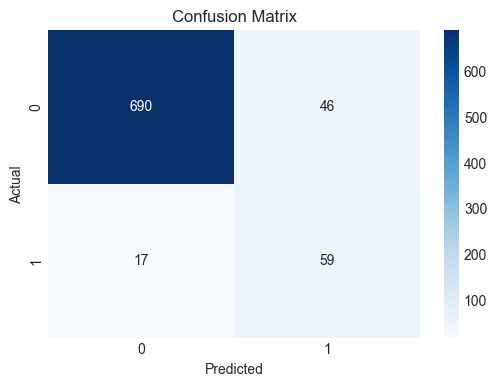

TN = 690, FP = 46
FN = 17, TP = 59


In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(f"TN = {cm[0,0]}, FP = {cm[0,1]}")
print(f"FN = {cm[1,0]}, TP = {cm[1,1]}")


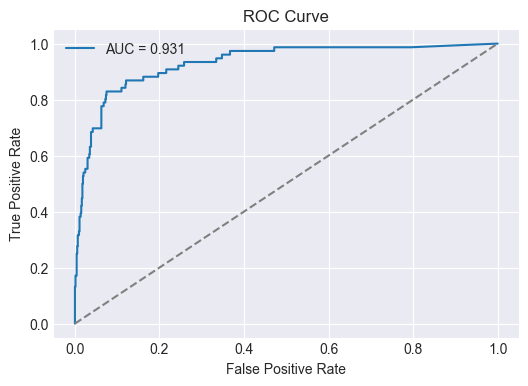

In [16]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


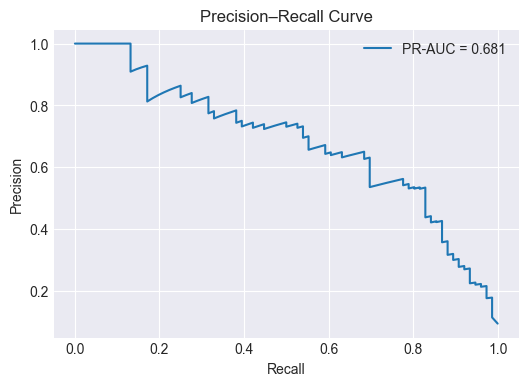

In [17]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(recalls, precisions, label=f"PR-AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.show()


In [18]:
import pandas as pd

errors = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": y_pred,
    "proba": y_proba
})

false_positives = errors[(errors.y_true == 0) & (errors.y_pred == 1)]
false_negatives = errors[(errors.y_true == 1) & (errors.y_pred == 0)]

print("🚨 Error Counts:")
print(f"False Positives: {len(false_positives)}")
print(f"False Negatives: {len(false_negatives)}")

false_positives.head(), false_negatives.head()


🚨 Error Counts:
False Positives: 46
False Negatives: 17


(     y_true  y_pred     proba
 33        0       1  0.593754
 53        0       1  0.891229
 60        0       1  0.718540
 68        0       1  0.536950
 157       0       1  0.563972,
      y_true  y_pred     proba
 1         1       0  0.109083
 128       1       0  0.282810
 206       1       0  0.050667
 230       1       0  0.458072
 256       1       0  0.275155)

In [19]:
FP = cm[0,1]
FN = cm[1,0]

cost_FP = FP * 2000      # example cost
cost_FN = FN * 20000     # missing a fraud is much more expensive

print("\n💰 Estimated Financial Impact:")
print(f"False Positives Cost: ${cost_FP:,}")
print(f"False Negatives Cost: ${cost_FN:,}")
print(f"Total Estimated Cost: ${cost_FP + cost_FN:,}")



💰 Estimated Financial Impact:
False Positives Cost: $92,000
False Negatives Cost: $340,000
Total Estimated Cost: $432,000


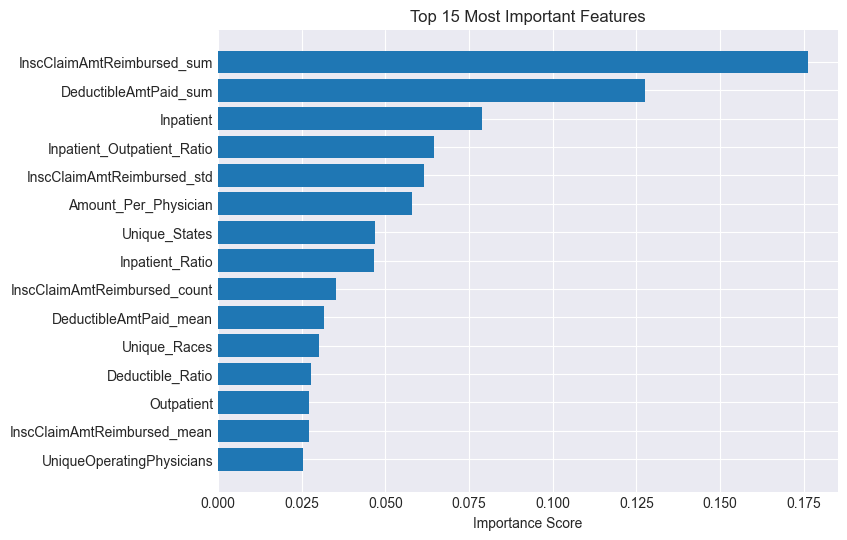

In [20]:
import numpy as np

importance = best_model.feature_importances_
sorted_idx = np.argsort(importance)[-15:]  # top 15 most important features

plt.figure(figsize=(8, 6))
plt.barh(np.array(feature_names)[sorted_idx], importance[sorted_idx])
plt.title("Top 15 Most Important Features")
plt.xlabel("Importance Score")
plt.show()
